In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import concatenate, Dense, Input, Flatten
from keras.optimizers import *
import gym
from rl.agents import eventDDPGAgent
from rl.memory import SequentialMemory

Using TensorFlow backend.
/Users/admin/.pyenv/versions/3.6.6/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# GymのPendulum環境を作成
env = gym.make("Pendulum-v0")

# 取りうる”打ち手”のアクション数と値の定義
nb_actions = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(3, activation="tanh")(x)
    actor = Model(inputs=action_input, outputs=x)
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

In [4]:
def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = eventDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com=0.01
    )
    return agent

W1014 08:16:49.977046 140735584400256 deprecation_wrapper.py:119] From /Users/admin/.pyenv/versions/3.6.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1014 08:16:50.004721 140735584400256 deprecation_wrapper.py:119] From /Users/admin/.pyenv/versions/3.6.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1014 08:16:50.032976 140735584400256 deprecation_wrapper.py:119] From /Users/admin/.pyenv/versions/3.6.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4158: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1014 08:16:50.202837 140735584400256 deprecation_wrapper.py:119] From /Users/admin/.pyenv/versions/3.6.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is de

Training for 1000000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 48s 5ms/step - reward: -7.1061
50 episodes - episode_reward: -1421.222 [-1867.770, -887.815] - loss: 3.018 - mean_squared_error: 6.036 - mean_q: -31.298

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 54s 5ms/step - reward: -6.3743
50 episodes - episode_reward: -1274.855 [-1747.212, -770.709] - loss: 17.126 - mean_squared_error: 34.253 - mean_q: -80.019

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 52s 5ms/step - reward: -4.5899
50 episodes - episode_reward: -917.975 [-1650.610, -100.442] - loss: 32.999 - mean_squared_error: 65.998 - mean_q: -112.141

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 52s 5ms/step - reward: -4.5703
50 episodes - episode_reward: -914.063 [-1758.972, -100.365] - loss: 56.339 - mean_squared_error: 112.677 - mean_q: -140.706

Interval 5 (40000 step

10000/10000 [==============================] - 54s 5ms/step - reward: -3.6211
50 episodes - episode_reward: -724.230 [-1517.342, -98.188] - loss: 35.293 - mean_squared_error: 70.585 - mean_q: -104.225

Interval 36 (350000 steps performed)
10000/10000 [==============================] - 54s 5ms/step - reward: -4.2171
50 episodes - episode_reward: -843.410 [-1458.701, -98.627] - loss: 40.882 - mean_squared_error: 81.764 - mean_q: -105.489

Interval 37 (360000 steps performed)
10000/10000 [==============================] - 55s 5ms/step - reward: -5.1460
50 episodes - episode_reward: -1029.208 [-1642.828, -559.049] - loss: 46.176 - mean_squared_error: 92.353 - mean_q: -111.129

Interval 38 (370000 steps performed)
10000/10000 [==============================] - 54s 5ms/step - reward: -2.8041
50 episodes - episode_reward: -560.819 [-1227.514, -101.097] - loss: 44.037 - mean_squared_error: 88.074 - mean_q: -102.426

Interval 39 (380000 steps performed)
10000/10000 [============================

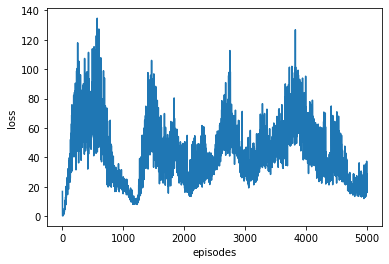

Finish Learning. We start test phase.


In [5]:
#通信によるコストの強さを設定
l = .5
agent = agent((3,), env.observation_space.shape) #agent((actor output dim),(state_dim))
opt = 'adam'

if opt == 'adam':
    #adam optimizer
    agent.compile(Adam(lr=0.001, clipnorm=1., decay = 0), metrics=["mse"])
elif opt == 'adadelta':
    #adadelta optimizer
    agent.compile(Adadelta(), metrics=['mse'])
elif opt == 'adagrad':
    #adagrad optimizer
    agent.compile(Adagrad(), metrics=['mse'])
else:
    assert False

agent.fit(env, lam=l, nb_steps=1000000, visualize=0, verbose=1, nb_max_episode_steps=200, loss_graph=1)
print('Finish Learning. We start test phase.')
#agent.test(env, lam=l, nb_episodes=5, visualize=0, nb_max_episode_steps=200)

Finish Learning. We start test phase.
Testing for 5 episodes ...
Episode 1: reward: -103.213, steps: 200


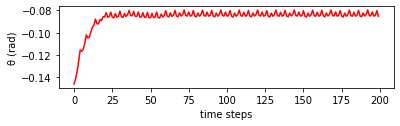

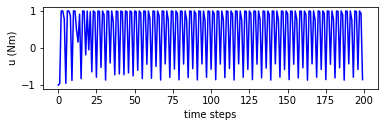

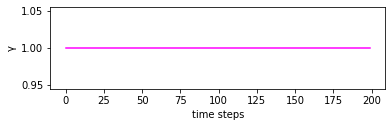

Episode 2: reward: -688.106, steps: 200


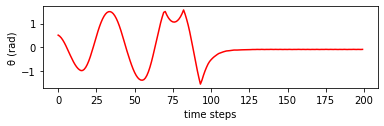

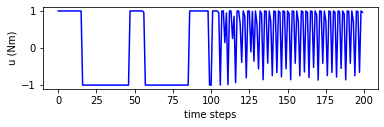

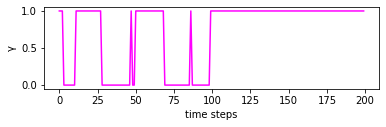

Episode 3: reward: -562.934, steps: 200


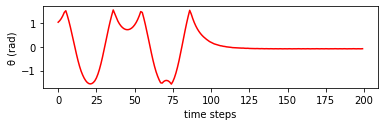

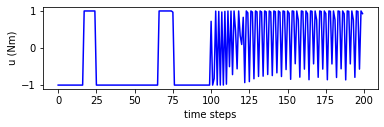

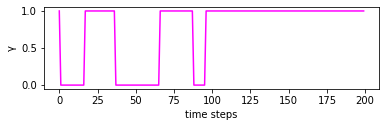

Episode 4: reward: -929.312, steps: 200


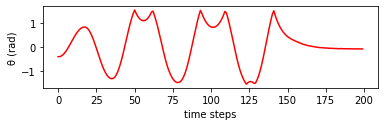

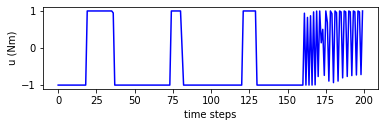

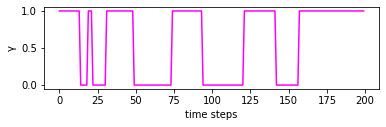

Episode 5: reward: -1268.165, steps: 200


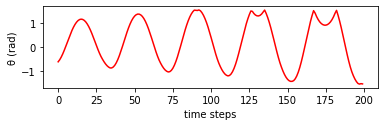

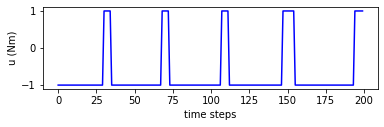

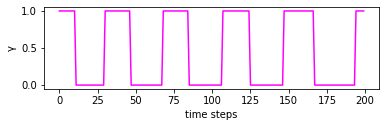

In [6]:
#agent.fit(env, lam=l, nb_steps=50000, visualize=True, verbose=1, nb_max_episode_steps=200)
print('Finish Learning. We start test phase.')
agent.test(env, lam=l, nb_episodes=5, visualize=0, nb_max_episode_steps=200, graph=True,action_view=0)

Training for 10000 steps ...
Interval 1 (0 steps performed)
 5249/10000 [==============>...............] - ETA: 30s - reward: nandone, took 33.188 seconds


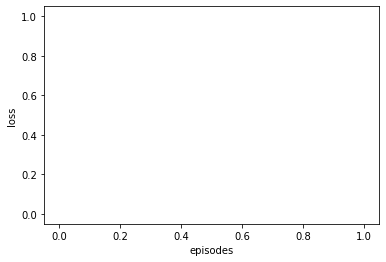

In [19]:
agent.fit(env, lam=l, nb_steps=10000, visualize=0, verbose=1, nb_max_episode_steps=200, loss_graph=1)

In [1]:
agent.save_weights('0.5free_model_test.h5')

NameError: name 'agent' is not defined

$\lambda = 1$だと15万ステップ学習してもダメ

$\lambda = 0.1$だと1万5千くらいから立ち始める。その時はたってからは毎回通信。

In [6]:
for i in range(11):
    l = i*0.2
    def agent(a_shape, s_shape):
        actor = actor_net(a_shape, s_shape)
        critic,  critic_action_input = critic_net(a_shape, s_shape)
        memory = SequentialMemory(limit = 50000, window_length = 1)
        agent = eventDDPGAgent(
            a_shape[0],
            actor,
            critic,
            critic_action_input,
            memory
        )
        return agent

    a = agent((3,), env.observation_space.shape)
    a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
    a.fit(env, lam=l, nb_steps=50000, visualize=1, verbose=1, nb_max_episode_steps=200)
    a.save_weights(f'learned_models/normal{l}.h5')

Training for 50000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 152s 15ms/step - reward: -7.6021
50 episodes - episode_reward: -1520.418 [-1848.082, -926.173] - loss: 3.034 - mean_absolute_error: 0.515 - mean_q: -32.362

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 167s 17ms/step - reward: -6.1389
50 episodes - episode_reward: -1227.779 [-1853.759, -752.904] - loss: 19.983 - mean_absolute_error: 1.015 - mean_q: -85.907

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 168s 17ms/step - reward: -4.3081
50 episodes - episode_reward: -861.618 [-1656.482, -226.366] - loss: 39.277 - mean_absolute_error: 1.756 - mean_q: -112.669

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 167s 17ms/step - reward: -3.9846
50 episodes - episode_reward: -796.920 [-1477.454, -451.134] - loss: 53.780 - mean_absolute_error: 2.436 - mean_q: -125.479

Interval 5 (4000

Training for 150000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 60s 6ms/step - reward: -1.5935
50 episodes - episode_reward: -318.692 [-727.146, -1.055] - loss: 30.884 - mean_squared_error: 61.767 - mean_q: -66.899

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 63s 6ms/step - reward: -1.6722
50 episodes - episode_reward: -334.447 [-644.433, -0.792] - loss: 22.827 - mean_squared_error: 45.653 - mean_q: -39.455

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 64s 6ms/step - reward: -2.0309
50 episodes - episode_reward: -406.185 [-1731.487, -0.861] - loss: 20.777 - mean_squared_error: 41.554 - mean_q: -27.843

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 64s 6ms/step - reward: -2.3320
50 episodes - episode_reward: -466.399 [-1734.120, -1.240] - loss: 19.490 - mean_squared_error: 38.980 - mean_q: -20.356

Interval 5 (40000 steps performed)
1

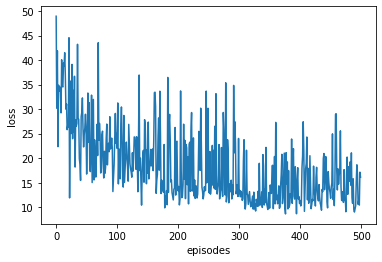

In [12]:
agent.fit(env, lam=l, nb_steps=150000, visualize=0, verbose=1, nb_max_episode_steps=200, loss_graph=1)

Testing for 5 episodes ...
Episode 1: reward: -392.520, steps: 200


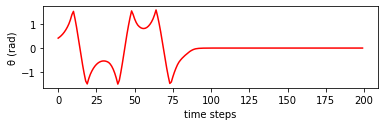

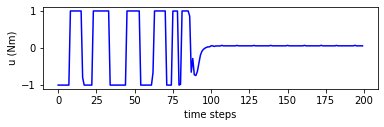

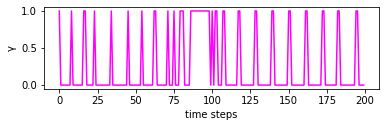

Episode 2: reward: -400.598, steps: 200


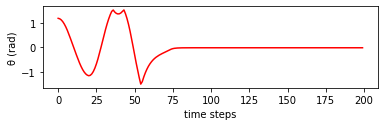

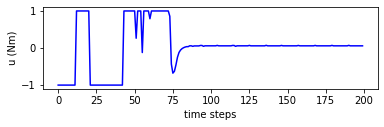

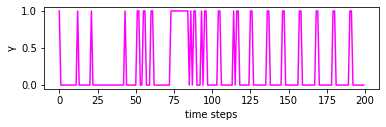

Episode 3: reward: -25.208, steps: 200


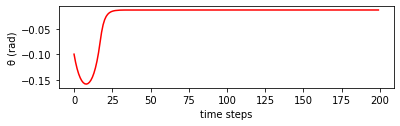

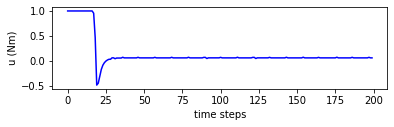

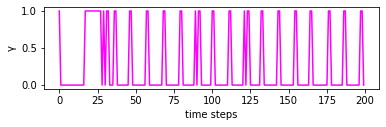

Episode 4: reward: -505.319, steps: 200


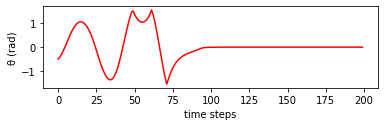

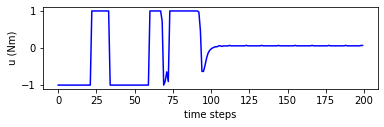

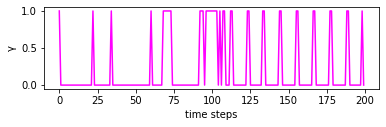

Episode 5: reward: -1006.071, steps: 200


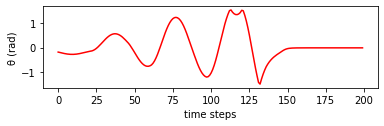

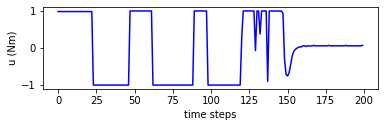

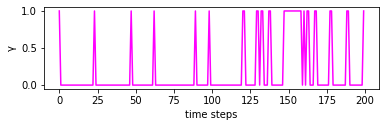

In [25]:
agent.test(env, lam=l, nb_episodes=5, visualize=0, nb_max_episode_steps=200, graph=True,action_view=0)

In [17]:
np.clip(2,-1,1)

1